In [1]:
#General imports needed for path
import os 
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

#import for plots
import matplotlib.pyplot as plt

In [2]:
import route_dynamics.route_elevation.base_df as base
import route_dynamics.route_energy.knn as knn
from route_dynamics.route_riders import route_riders as ride
import route_dynamics.route_energy.longi_dynam_model as ldm
import route_dynamics.route_energy.accel as ca

import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import mapping
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
#User defines what routes they want to evaluate
rt_list = [22]

#Import data files
shapefile_name = '../data/rt' + str(rt_list[0]) + '_pts2.shp'
stops_shp = '../data/Transit_Stops_for_King_County_Metro__transitstop_point.shp'
a_prof = pd.read_csv("../data/acceleration.csv", names=['time (s)', 'accel. (g)'])
signals_shp = '../data/traffic_signals2.shp'

#Initialize route dataframe
rt_df = base.wrapper(shapefile_name, 6, 6)

In [4]:
rt_df.head()

,geometry,distance,elevation,speed_limit,grade
0,POINT (-122.38813 47.56295),0.0000,99.398090,11.175682,0.000000
1,POINT (-122.38798 47.56295),10.9728,99.874774,11.175682,0.043442
2,POINT (-122.38784 47.56295),21.9456,100.272354,11.175682,0.036233
3,POINT (-122.38769 47.56295),32.9184,100.594760,11.175682,0.029382
4,POINT (-122.38754 47.56295),43.8912,100.845922,11.175682,0.022889


In [5]:
period = 'PM'
route = 22

In [6]:
trip183 = pd.read_csv("../data/Trip183.csv", usecols = ['SignRt', 'InOut', 'KeyTrip', 'BusType', 'Seats', 
                     'Period', 'AnnRides']) # KCM Data
trip183unsum = pd.read_csv("../data/Zon183Unsum.csv", usecols = ['Route', 'Dir', 'Trip_ID', 'InOut', 'STOP_SEQ', 'STOP_ID',
                     'Period', 'AveOn', 'AveOff', 'AveLd', 'Obs']) # KCM Data

In [7]:
trip_df = ride.route_ridership('PM', rt_list[0], 14000)
geometry = trip_df.geometry.values

In [8]:
xy = []
for i in range(len(geometry)):
    dic = mapping(geometry[i][0])
    coords = dic['coordinates']
    xy.append(coords)
    xy_df = pd.DataFrame(columns = ['STOP_ID','coordinates'])
    xy_df['coordinates'] = xy
    
xy_df

stop_coords = xy_df.coordinates.values

In [9]:
signals = gpd.read_file(signals_shp)
signals = signals[signals['Route_Num']==str(rt_list[0])]
geometry = signals.geometry.values
xy = []
for i in range(len(geometry)):
    dic = mapping(geometry[i])
    coords = dic['coordinates']
    xy.append(coords)
    xy_df = pd.DataFrame(columns = ['STOP_ID','coordinates'])
    xy_df['coordinates'] = xy
    
xy_df

signal_coords = xy_df.coordinates.values

In [10]:
# add stops to bus dataframe

stop_nn_indicies, stop_coord_nn = knn.find_knn(
                1,
                rt_df.geometry.values,
                stop_coords
                )

In [11]:
signal_nn_indicies, signal_coord_nn = knn.find_knn(
                1,
                rt_df.geometry.values,
                signal_coords
                )

In [12]:
rt_df = rt_df.assign(
                is_bus_stop = ([False] * len(rt_df.index))
                )

rt_df = rt_df.assign(
                is_signal = ([False] * len(rt_df.index))
                )

rt_df = rt_df.assign(
                is_stop = ([False] * len(rt_df.index))
                )

for i in stop_nn_indicies.ravel()[::2]:
    rt_df.at[i, 'is_bus_stop'] = True
    rt_df.at[i, 'is_stop'] = True
    
for i in signal_nn_indicies.ravel()[::2]:
    rt_df.at[i, 'is_signal'] = True
    rt_df.at[i, 'is_stop'] = True

In [13]:
true_count = rt_df.is_bus_stop.sum()
true_count

44

In [14]:
rt_df.head()

,geometry,distance,elevation,speed_limit,grade,is_bus_stop,is_signal,is_stop
0,POINT (-122.38813 47.56295),0.0000,99.398090,11.175682,0.000000,False,False,False
1,POINT (-122.38798 47.56295),10.9728,99.874774,11.175682,0.043442,False,False,False
2,POINT (-122.38784 47.56295),21.9456,100.272354,11.175682,0.036233,False,False,False
3,POINT (-122.38769 47.56295),32.9184,100.594760,11.175682,0.029382,False,False,False
4,POINT (-122.38754 47.56295),43.8912,100.845922,11.175682,0.022889,False,False,False


In [15]:
mass_array = trip_df.Total_Mass.values

In [16]:
unloaded_bus_mass = 14000

In [17]:
# Initialize array of Nan's for mass column of rdf
full_mass_column = np.zeros(len(rt_df.index))
full_mass_column[:] = np.nan


In [39]:
np.sort(stop_nn_indicies.ravel())

array([   7,   37,   61,   64,   89,  110,  134,  139,  156,  159,  169,
        181,  190,  200,  202,  211,  226,  240,  248,  268,  270,  285,
        302,  303,  319,  320,  334,  351,  414,  502,  550,  571,  615,
        615,  640,  656,  676,  694,  703,  722,  741,  748,  767,  784,
        802,  815,  831,  844,  864,  879,  895,  904,  914,  927,  939,
        955,  988, 1022, 1036, 1061, 1109, 1117, 1118, 1127, 1131, 1135,
       1207, 1217, 1220, 1246, 1247, 1270, 1290, 1339, 1362, 1364, 1372,
       1384, 1392, 1413, 1440, 1452, 1475, 1509, 1538, 1594, 1610, 1610])

In [18]:
test = stop_nn_indicies.ravel()
order = np.sort(test)

In [19]:
# Iterate through the length of the given mass_array
# (already determined equal length to 'stop_coords').
for i in range(len(mass_array)):
    # Set values of mass at bus_stops
    full_mass_column[
        order[i]
        ] = mass_array[i]

# Set initial and value to unloaded bus mass.
full_mass_column[0] = unloaded_bus_mass
full_mass_column[-1] = unloaded_bus_mass

# Iterate through the half constructed rdf mass column
# ('full_mass_column') and fill in sapce between stops with previous value
for i in range(len(full_mass_column)-1):
        if np.isnan(full_mass_column[i]):
            full_mass_column[i] = full_mass_column[i-1]
        else:
            continue 

In [20]:
rt_df = rt_df.assign(
            mass = full_mass_column
            )

In [21]:
rt_df.head()

,geometry,distance,elevation,speed_limit,grade,is_bus_stop,is_signal,is_stop,mass
0,POINT (-122.38813 47.56295),0.0000,99.398090,11.175682,0.000000,False,False,False,14000.0
1,POINT (-122.38798 47.56295),10.9728,99.874774,11.175682,0.043442,False,False,False,14000.0
2,POINT (-122.38784 47.56295),21.9456,100.272354,11.175682,0.036233,False,False,False,14000.0
3,POINT (-122.38769 47.56295),32.9184,100.594760,11.175682,0.029382,False,False,False,14000.0
4,POINT (-122.38754 47.56295),43.8912,100.845922,11.175682,0.022889,False,False,False,14000.0


In [22]:
a_prof.head()

,time (s),accel. (g)
0,0.000000,0.000556
1,0.917431,0.115556
2,1.972477,0.123889
3,2.935780,0.126111
4,4.036697,0.125556


In [23]:
a_pos = 0.4
a_neg = -1.5

(accelerations,
const_a_velocities,
x_ls,
x_ns,
route_time, delta_times) = ca.accel_dynamics(rt_df,a_prof,a_pos,a_neg)

In [24]:
rt_df = rt_df.assign(acceleration=accelerations)

In [25]:
rt_df.head()

,geometry,distance,elevation,speed_limit,grade,is_bus_stop,is_signal,is_stop,mass,acceleration
0,POINT (-122.38813 47.56295),0.0000,99.398090,11.175682,0.000000,False,False,False,14000.0,0.000000
1,POINT (-122.38798 47.56295),10.9728,99.874774,11.175682,0.043442,False,False,False,14000.0,1.264274
2,POINT (-122.38784 47.56295),21.9456,100.272354,11.175682,0.036233,False,False,False,14000.0,1.226868
3,POINT (-122.38769 47.56295),32.9184,100.594760,11.175682,0.029382,False,False,False,14000.0,1.211556
4,POINT (-122.38754 47.56295),43.8912,100.845922,11.175682,0.022889,False,False,False,14000.0,1.092837


In [26]:
bus_speed_array = const_a_velocities

rt_df = rt_df.assign(velocity=bus_speed_array)

In [27]:
rt_df = rt_df.assign(delta_times = delta_times)
rt_df = rt_df.assign(total_time = route_time)
rt_df.head()

,geometry,distance,elevation,speed_limit,grade,is_bus_stop,is_signal,is_stop,mass,acceleration,velocity,delta_times,total_time
0,POINT (-122.38813 47.56295),0.0000,99.398090,11.175682,0.000000,False,False,False,14000.0,0.000000,0.000000,0.000000,0.000000
1,POINT (-122.38798 47.56295),10.9728,99.874774,11.175682,0.043442,False,False,False,14000.0,1.264274,3.186607,6.886949,6.886949
2,POINT (-122.38784 47.56295),21.9456,100.272354,11.175682,0.036233,False,False,False,14000.0,1.226868,4.815798,2.742425,9.629374
3,POINT (-122.38769 47.56295),32.9184,100.594760,11.175682,0.029382,False,False,False,14000.0,1.211556,5.766712,2.073799,11.703173
4,POINT (-122.38754 47.56295),43.8912,100.845922,11.175682,0.022889,False,False,False,14000.0,1.092837,7.085541,1.707560,13.410734


In [28]:
vels = rt_df.velocity.values
acce = rt_df.acceleration.values
grad = rt_df.grade.values
grad_angle = np.arctan(grad)


# Physical parameters
gravi_accel = 9.81
air_density = 1.225 # air density in kg/m3; consant for now,
    # eventaully input from weather API
v_wind = 0.0 # wind speed in km per hour; figure out component,
    # and also will come from weather API
fric_coeff = 0.01

# List of Bus Parameters for 40 foot bus
loaded_bus_mass = rt_df.mass.values

width = 2.6 # in m
height = 3.3 # in m
bus_front_area = width * height
drag_coeff = 0.34 # drag coefficient estimate from paper (???)
rw = 0.28575 # radius of wheel in m


# Calculate the gravitational force
grav_force = -(
    loaded_bus_mass * gravi_accel * np.sin(grad_angle)
    )

# Calculate the rolling friction
roll_fric = -(
    fric_coeff * loaded_bus_mass * gravi_accel * np.cos(grad_angle)
    )

# Calculate the aerodynamic drag
aero_drag = -(
    drag_coeff
    *
    bus_front_area
    *
    (air_density/2)
    *
    (vels-v_wind)
    )

# Calculate the inertial force
inertia = loaded_bus_mass * acce

In [29]:
rt_df = rt_df.assign(
    grav_force = grav_force,
    roll_fric = roll_fric,
    aero_drag = aero_drag,
    inertia = inertia,
    )

In [30]:
rt_df.head()

,geometry,distance,elevation,speed_limit,grade,is_bus_stop,is_signal,is_stop,mass,acceleration,velocity,delta_times,total_time,grav_force,roll_fric,aero_drag,inertia
0,POINT (-122.38813 47.56295),0.0000,99.398090,11.175682,0.000000,False,False,False,14000.0,0.000000,0.000000,0.000000,0.000000,-0.000000,-1373.400000,-0.000000,0.000000
1,POINT (-122.38798 47.56295),10.9728,99.874774,11.175682,0.043442,False,False,False,14000.0,1.264274,3.186607,6.886949,6.886949,-5960.746166,-1372.105867,-5.693782,17699.836163
2,POINT (-122.38784 47.56295),21.9456,100.272354,11.175682,0.036233,False,False,False,14000.0,1.226868,4.815798,2.742425,9.629374,-4973.011720,-1372.499354,-8.604796,17176.145379
3,POINT (-122.38769 47.56295),32.9184,100.594760,11.175682,0.029382,False,False,False,14000.0,1.211556,5.766712,2.073799,11.703173,-4033.625469,-1372.807542,-10.303875,16961.784873
4,POINT (-122.38754 47.56295),43.8912,100.845922,11.175682,0.022889,False,False,False,14000.0,1.092837,7.085541,1.707560,13.410734,-3142.818559,-1373.040360,-12.660339,15299.720907


In [31]:
charging_power_max=160000

f_resist = (
    rt_df.grav_force.values
    +
    rt_df.roll_fric.values
    +
    rt_df.aero_drag.values
    )

f_traction = rt_df.inertia.values - f_resist

velocity = rt_df.velocity.values

# calculate raw power before capping charging ability of bus
batt_power_exert = f_traction * velocity
raw_batt_power_exert = np.copy(batt_power_exert)

for i in range(len(batt_power_exert)):
    for i in range(len(batt_power_exert)):
        if batt_power_exert[i] < -charging_power_max:
            batt_power_exert[i] = -charging_power_max

        elif batt_power_exert[i] > charging_power_max:
            batt_power_exert[i] = charging_power_max

In [32]:
rt_df = rt_df.assign(
    power_output = batt_power_exert
    )

In [33]:
rt_df.head()

,geometry,distance,elevation,speed_limit,grade,is_bus_stop,is_signal,is_stop,mass,acceleration,velocity,delta_times,total_time,grav_force,roll_fric,aero_drag,inertia,power_output
0,POINT (-122.38813 47.56295),0.0000,99.398090,11.175682,0.000000,False,False,False,14000.0,0.000000,0.000000,0.000000,0.000000,-0.000000,-1373.400000,-0.000000,0.000000,0.000000
1,POINT (-122.38798 47.56295),10.9728,99.874774,11.175682,0.043442,False,False,False,14000.0,1.264274,3.186607,6.886949,6.886949,-5960.746166,-1372.105867,-5.693782,17699.836163,79787.488819
2,POINT (-122.38784 47.56295),21.9456,100.272354,11.175682,0.036233,False,False,False,14000.0,1.226868,4.815798,2.742425,9.629374,-4973.011720,-1372.499354,-8.604796,17176.145379,113316.984141
3,POINT (-122.38769 47.56295),32.9184,100.594760,11.175682,0.029382,False,False,False,14000.0,1.211556,5.766712,2.073799,11.703173,-4033.625469,-1372.807542,-10.303875,16961.784873,129050.495139
4,POINT (-122.38754 47.56295),43.8912,100.845922,11.175682,0.022889,False,False,False,14000.0,1.092837,7.085541,1.707560,13.410734,-3142.818559,-1373.040360,-12.660339,15299.720907,140493.817179


Text(0.5, 1, 'Load Profile for Route 22')

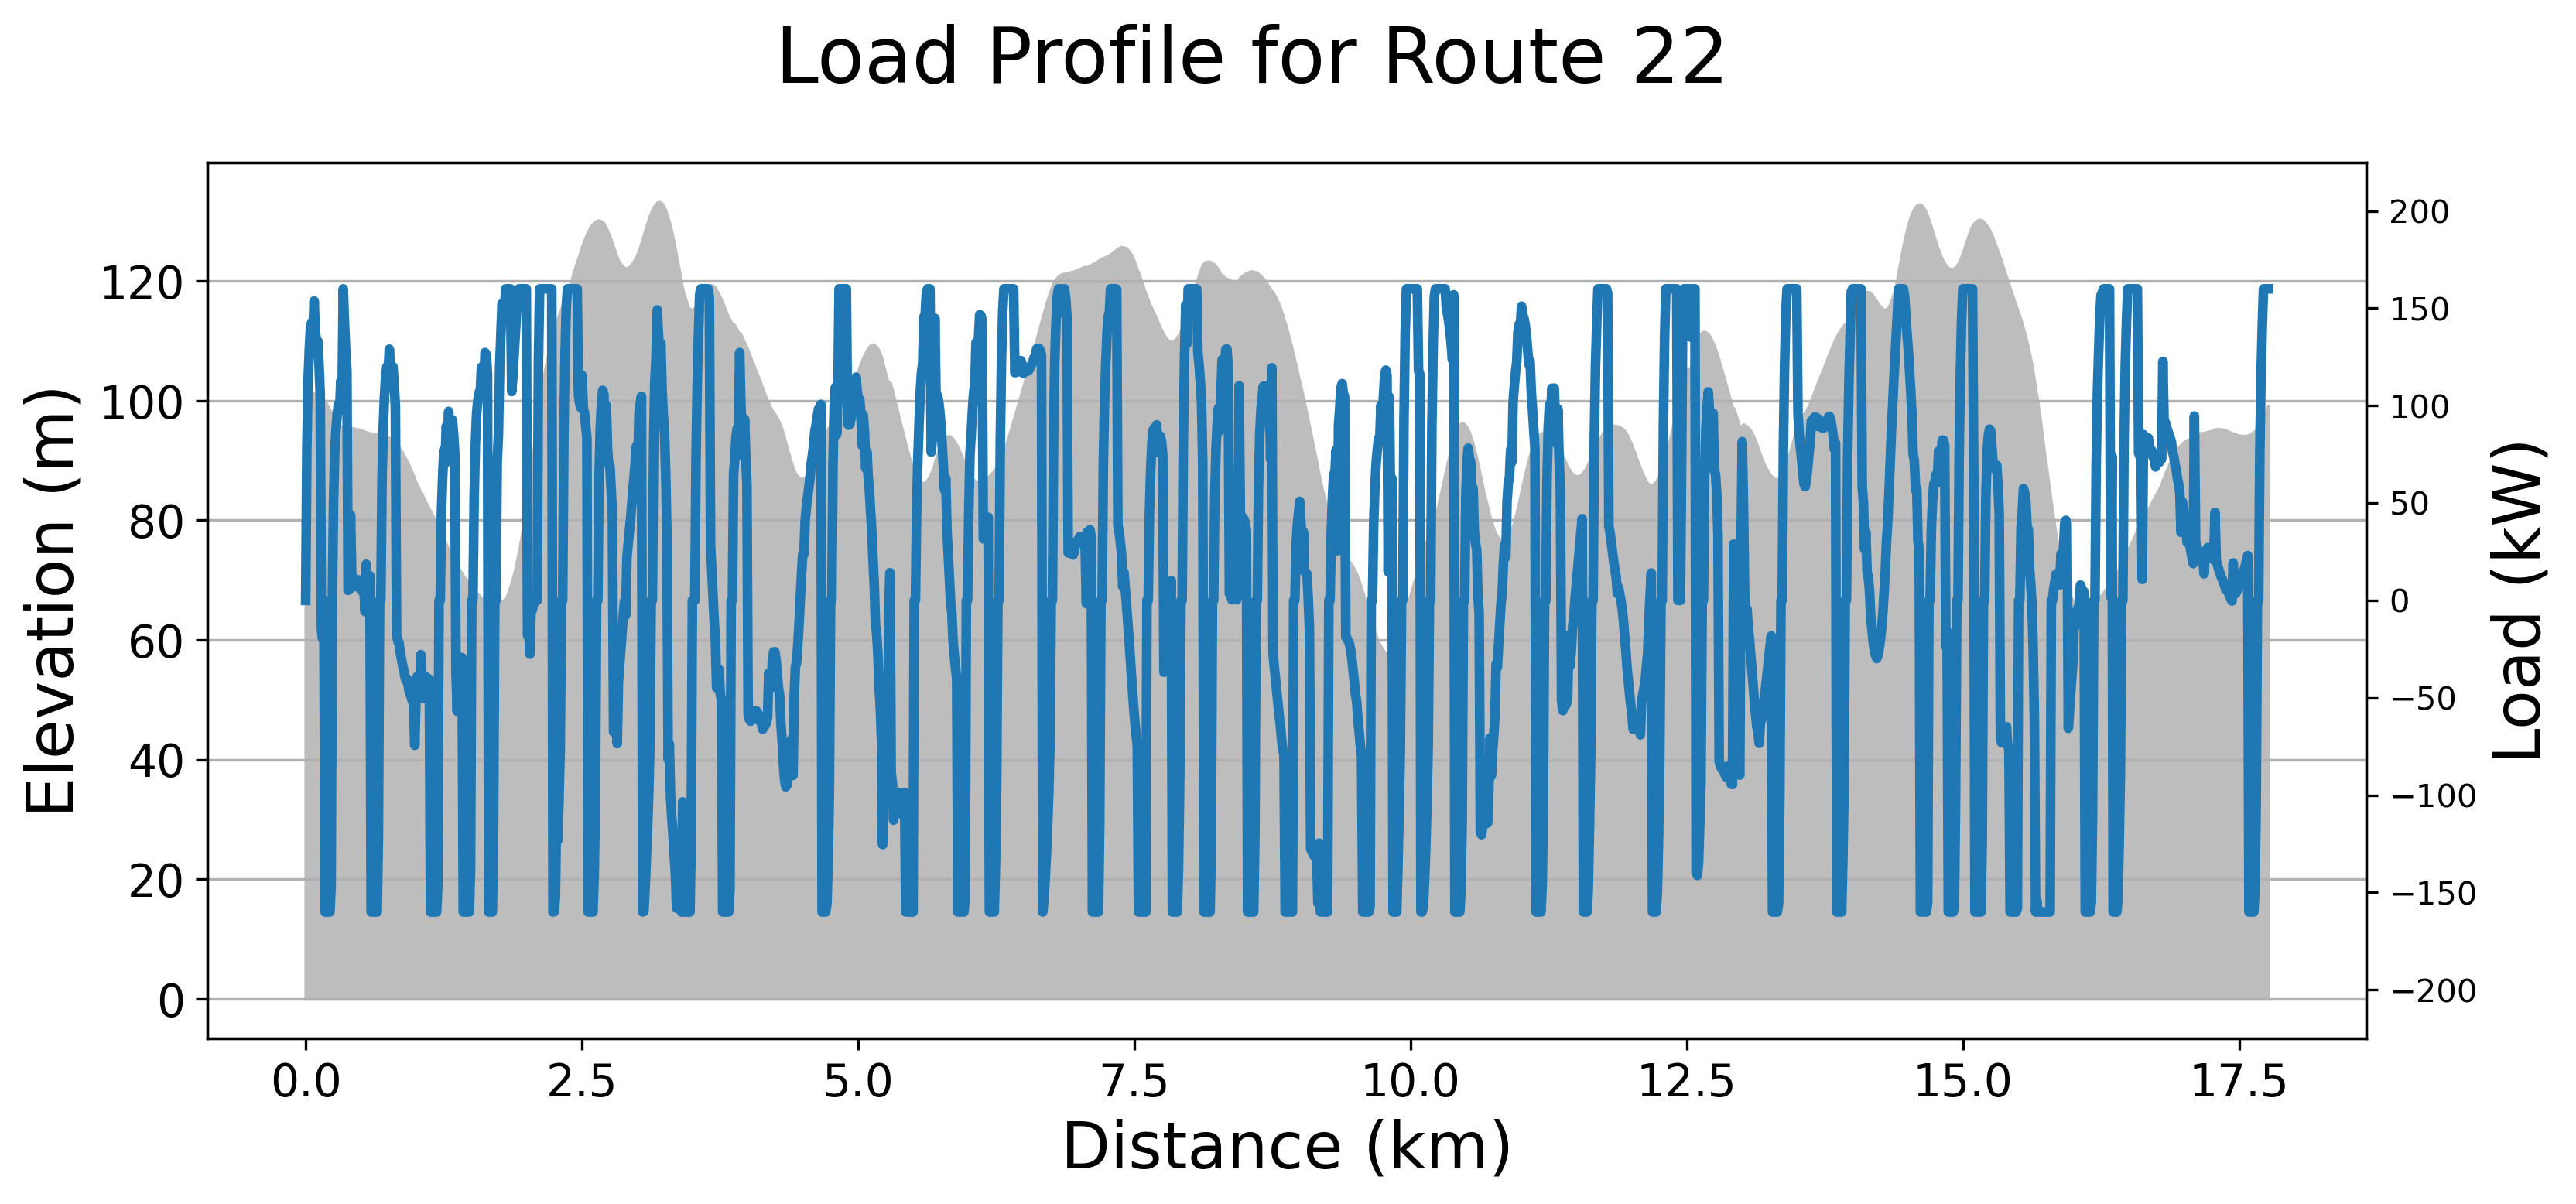

In [34]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.fill_between(rt_df['distance']/1000, rt_df['elevation'], color='#BDBDBD')
ax1 = ax.twinx()

ax1.plot(rt_df['distance']/1000, rt_df['power_output']/1000, linewidth=3)
ax1.set_ylabel('Load (kW)', fontsize=20)
ax1.set_ylim(-225, 225)
ax.set_xlabel('Distance (km)', fontsize=20)
ax.set_ylabel('Elevation (m)', fontsize=20)

ax.tick_params(labelsize=14)
ax.grid(axis='y')

fig.suptitle(
    'Load Profile for Route {}'.format(22),
    fontsize=24,
    y=1,
    )

    

Text(0.5, 1, 'Load Profile for Route 22')

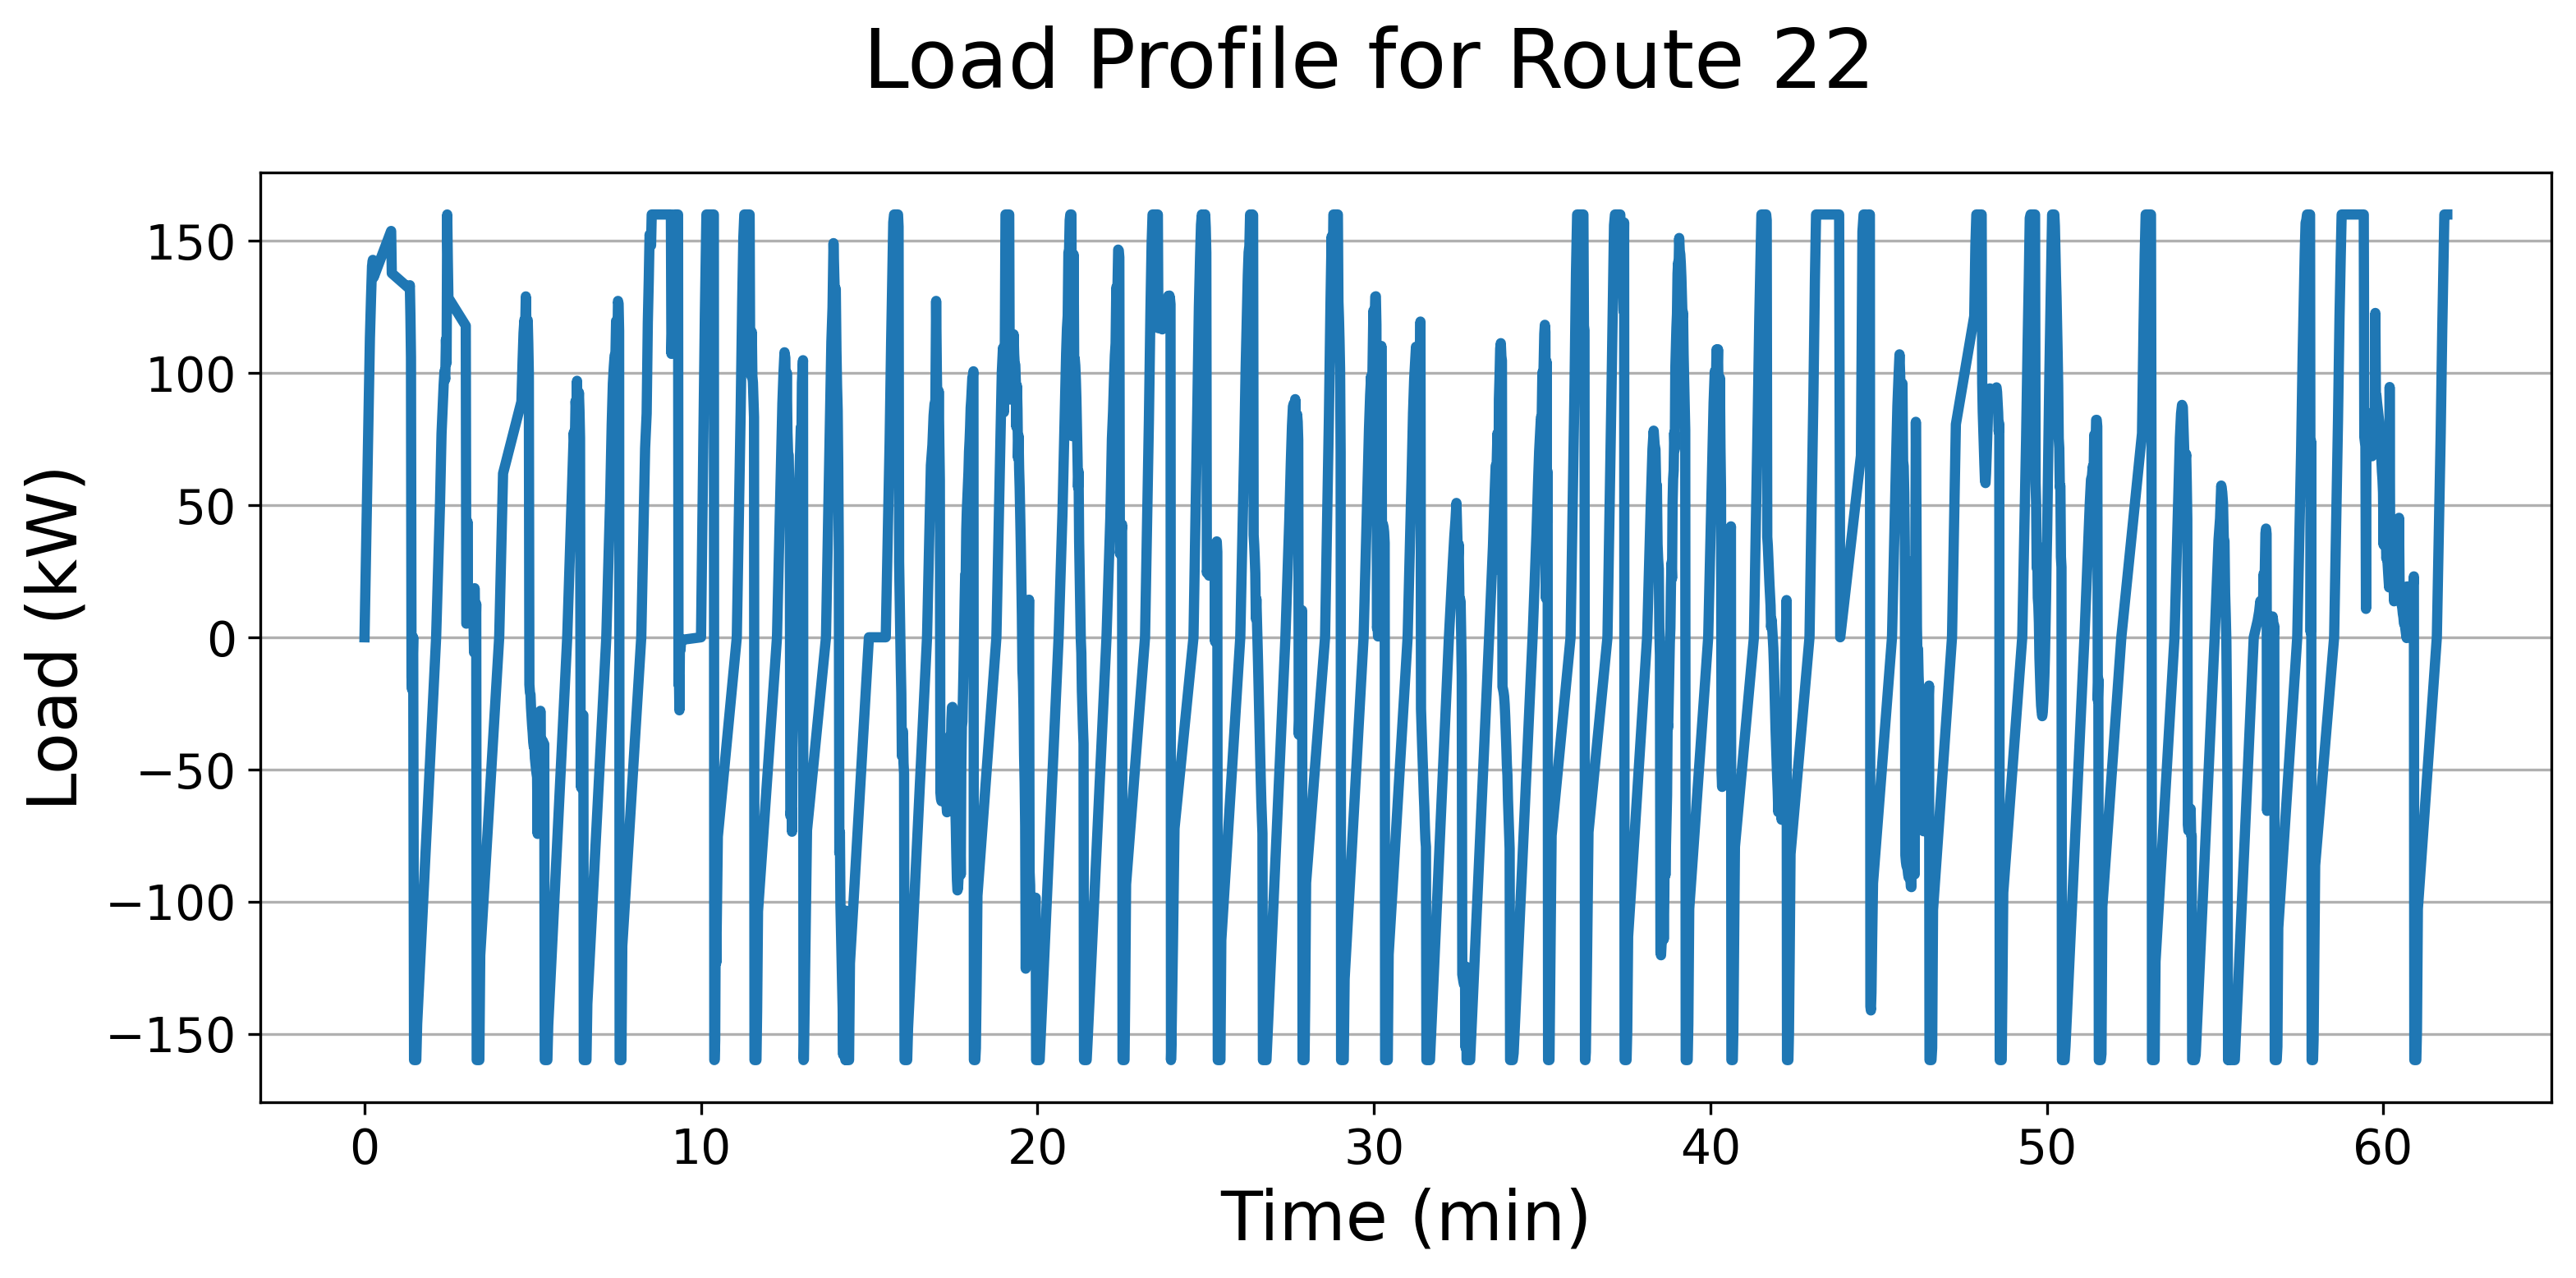

In [35]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.plot(rt_df['total_time']/60, rt_df['power_output']/1000, linewidth=3)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Load (kW)', fontsize=20)
ax.tick_params(labelsize=14)
ax.grid(axis='y')

fig.suptitle(
    'Load Profile for Route {}'.format(22),
    fontsize=24,
    y=1,
    )

Text(0.5, 1, 'Histogram for Route 22')

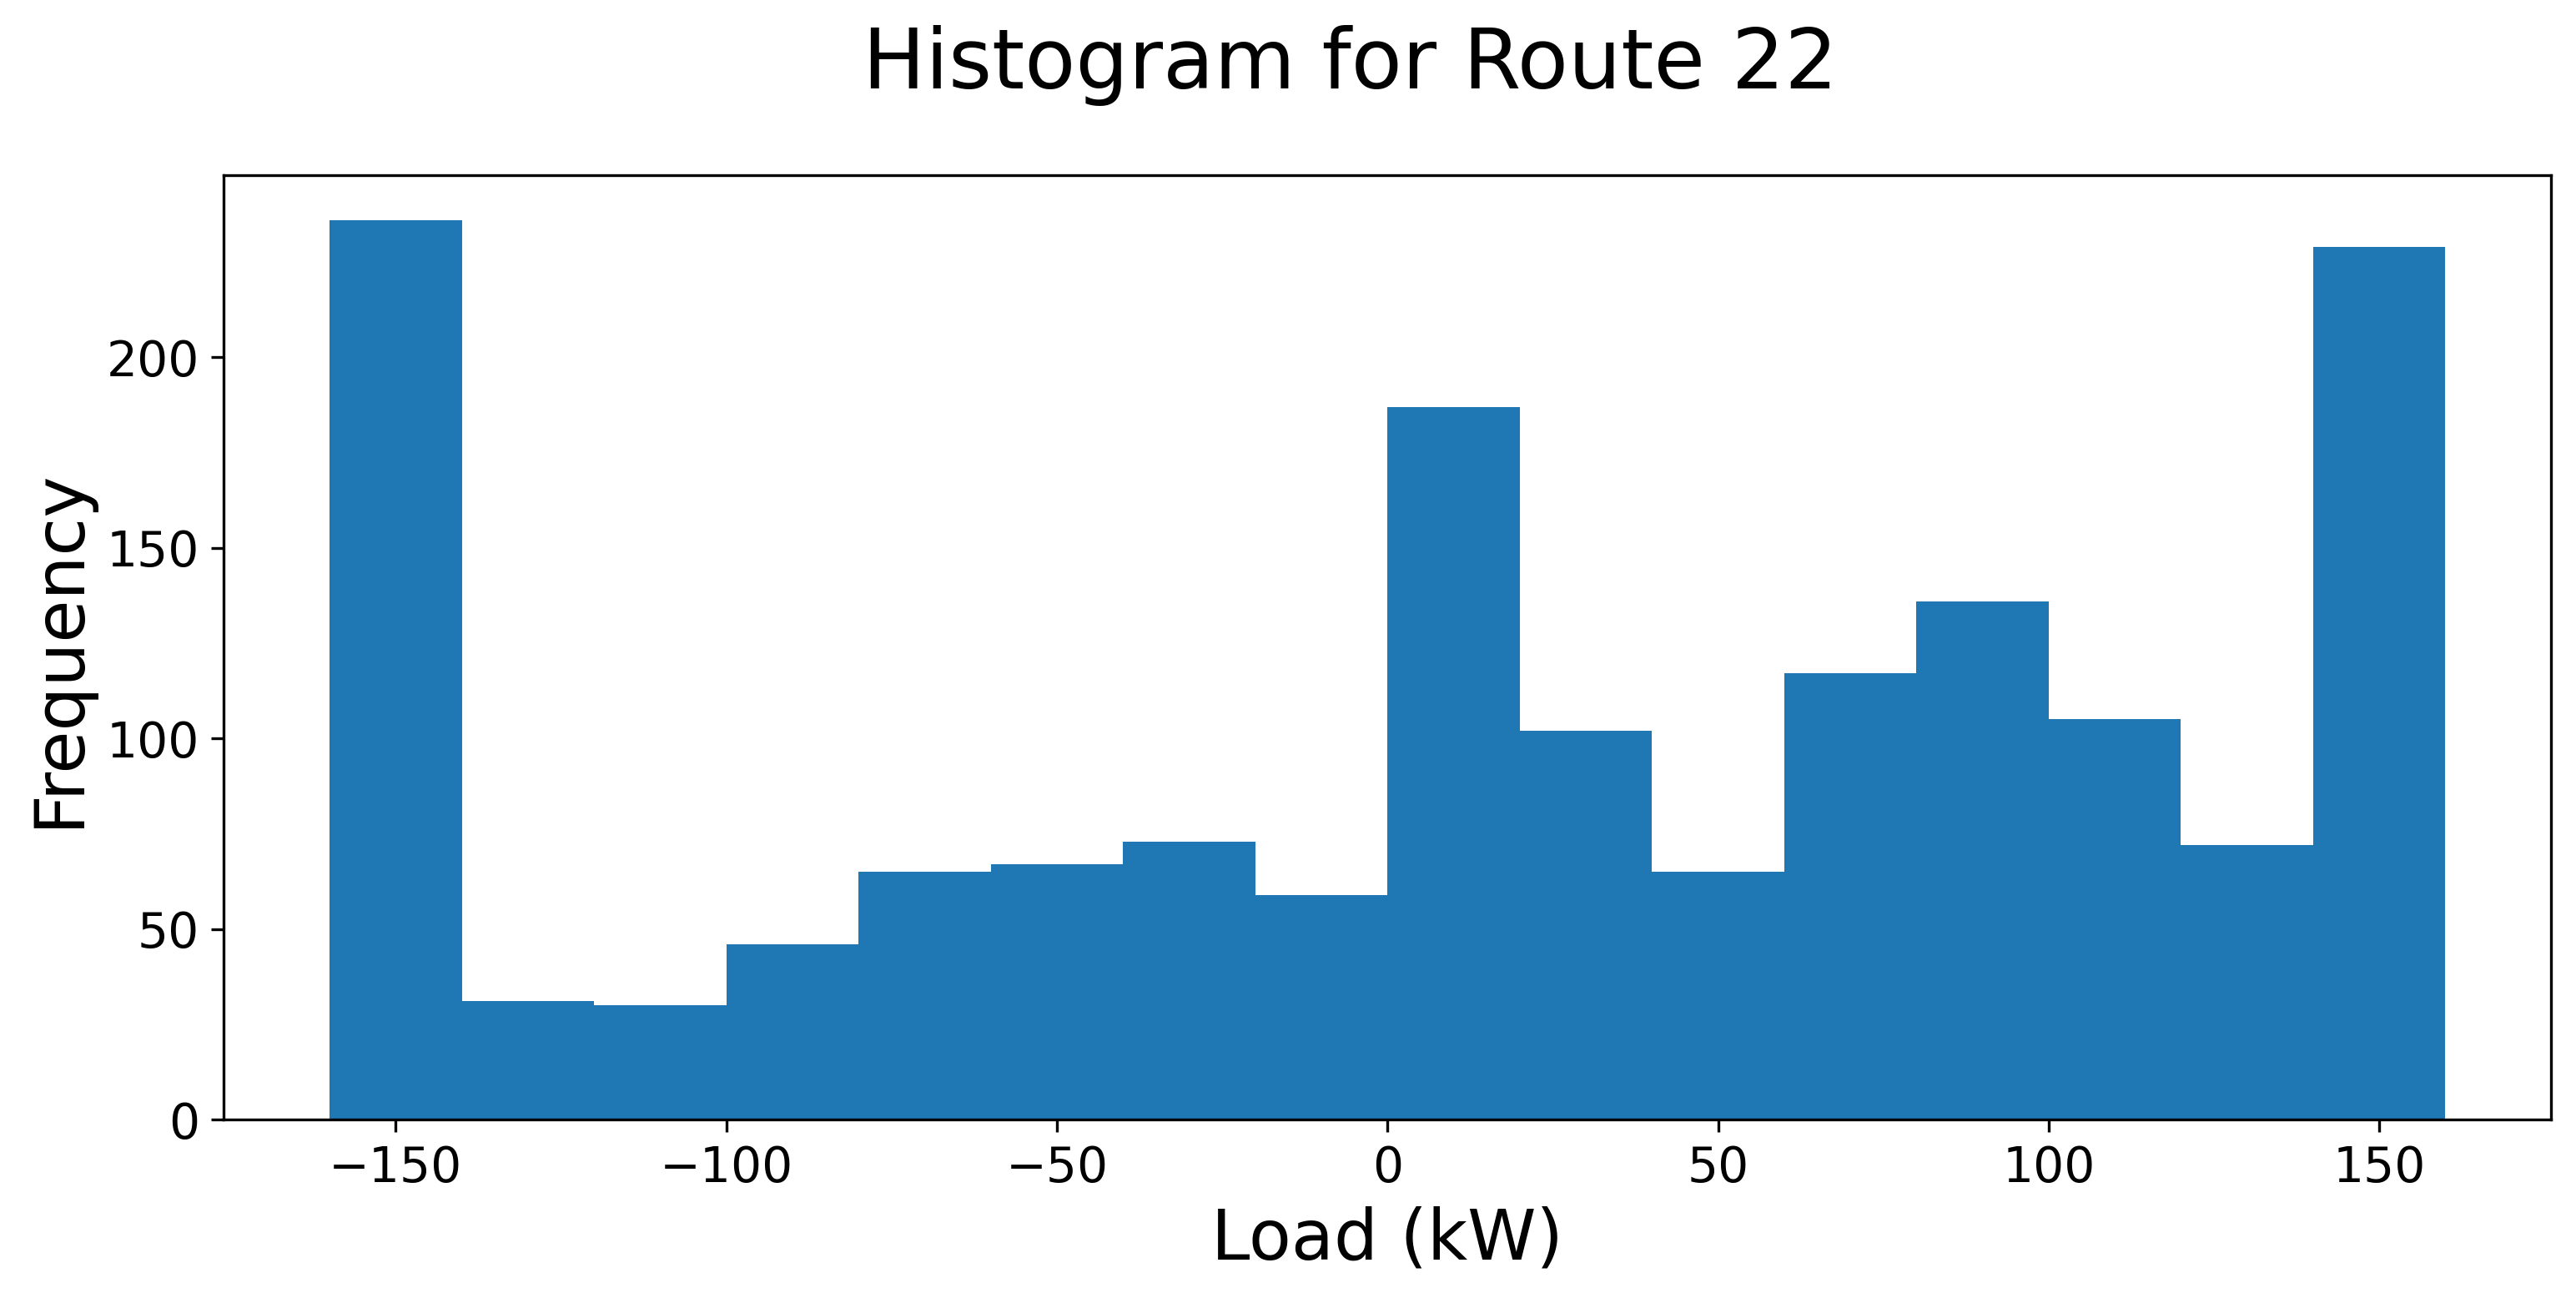

In [36]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.hist(rt_df['power_output']/1000, bins=16)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_xlabel('Load (kW)', fontsize=20)
ax.tick_params(labelsize=14)

fig.suptitle(
    'Histogram for Route {}'.format(22),
    fontsize=24,
    y=1,
    )